In [1]:
import argparse
import cv2
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image

from resnet_cifar.resnet import *
from vgg_cifar import vgg

## Define hyperparameters

In [2]:
class ResNet_agrument:
    def __init__(self):
        self.arch = 'vgg19'
        self.workers = 4
        self.batch_size = 4  # Sample images for inferencing   
        self.cpu = False
        self.dataset = 'cifar100'
        self.checkpoint = None
        self.block = ''

class VGG_agrument(ResNet_agrument):
    def __init__(self):
        super().__init__()
        self.arch = 'vgg19'
        self.dataset = 'cifar10'

In [3]:
resnet_names   = ['ResNet (base)', 'SE (residuel) + SA', 'SE + SA', 'CBAM', 'Our model']
resnet_blocks  = ['RESNET', 'SE_SA_1', 'SEC_SA_1', 'CBAM_1', 'NEW_1']
resnet_checkpoints = ['weights/resnet18/cifar100/RESNET/checkpoint_1.pth',
                      'weights/resnet18/cifar100/SE_SA_1/checkpoint_1.pth',
                      'weights/resnet18/cifar100/SEC_SA_1/checkpoint_1.pth',
                      'weights/resnet18/cifar100/CBAM_1/checkpoint_1.pth',
                      'weights/resnet18/cifar100/NEW_1/checkpoint_1.pth']

vgg_names   = ['VGG19 (base)', 'SE (residuel) + SA', 'SE + SA', 'CBAM', 'Our model']
vgg_blocks  = ['VGG19', 'SE_SA_1', 'SEC_SA_1', 'CBAM_1', 'NEW_1']
vgg_checkpoints = ['weights/vgg19/cifar10/VGG19/checkpoint_1.tar',
                   'weights/vgg19/cifar10/SE_SA_1/checkpoint_1.tar',
                   'weights/vgg19/cifar10/SEC_SA_1/checkpoint_1.tar',
                   'weights/vgg19/cifar10/CBAM_1/checkpoint_1.tar',
                   'weights/vgg19/cifar10/NEW_1/checkpoint_1.tar']

## Set the random seed and the class names

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Label and its index for CIFAR10
# https://www.cs.toronto.edu/~kriz/cifar.html
class_cifar10 = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
                 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Label and its index for CIFAR100
# https://huggingface.co/datasets/cifar100
class_cifar100 = {0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle',
                  8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly',
                  15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee',
                  22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'cra', 27: 'crocodile', 28: 'cup',
                  29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl',
                  36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower',
                  42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle',
                  49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter',
                  56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate',
                  62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road',
                  69: 'rocket', 70: 'rose', 71: 'sea', 72: 'seal', 73: 'shark', 74: 'shrew', 75: 'skunk',
                  76: 'skyscraper', 77: 'snail', 78: 'snake', 79: 'spider', 80: 'squirrel', 81: 'streetcar',
                  82: 'sunflower', 83: 'sweet_pepper', 84: 'table', 85: 'tank', 86: 'telephone', 87: 'television',
                  88: 'tiger', 89: 'tractor', 90: 'train', 91: 'trout', 92: 'tulip', 93: 'turtle', 94: 'wardrobe',
                  95: 'whale', 96: 'willow_tree', 97: 'wolf', 98: 'woman', 99: 'worm'}

# 1. ResNet18 Inference

## 1.1 Define functions

In [6]:
def resnet_inference(args):
    #############################################
    # Load dataset
    #############################################
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    if args.dataset == "cifar100":
        num_classes = 100
        classes = class_cifar100
        val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True)
    else:  # default dataset is CIFAR10
        num_classes = 10
        classes = class_cifar10
        val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True)

    print("dataset :", args.dataset)
    print("checkpoint :", args.checkpoint)

    #############################################
    # Load model
    #############################################
    model = ResNet18(block=args.block, num_classes=num_classes)
    # print(model.layer4)

    cam_layers = [model.layer4]

    device = 'cuda' if torch.cuda.is_available() and not args.cpu else 'cpu'

    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)

    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['net'])

    #############################################
    # Evaluate model
    #############################################
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    print("images shape : ", images.shape)
    #img = torchvision.utils.make_grid(images)
    #images = images / 2 + 0.5     # unnormalize
    #npimg = images.numpy()
    #print("npimg shape : ", npimg.shape)
    torchvision.utils.save_image(images, "gradCAM_seed%d_input.jpg" % seed, nrow=4, normalize=True, range=(-1, 1))
    print("input gt labels : ")
    np_labels = labels.detach().cpu()
    print([classes[int(np_labels[j])] for j in range(args.batch_size)])
    output = model(images)
    maxk = 1
    pred = output.topk(maxk, 1, True, True)
    # print("pred : ", pred)
    print("pred labels : ")
    np_indices = pred.indices.detach().cpu()
    print([classes[int(np_indices[j][0])] for j in range(args.batch_size)])

    #############################################
    # Create CAM
    #############################################
    cam = GradCAM(model=model, target_layers=cam_layers, use_cuda=False if device == 'cpu' else True)
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=False if device == 'cpu' else True)

    grayscale_cams = cam(input_tensor=images)

    original_img = None
    final_cam = None
    for idx, grayscale_cam in enumerate(grayscale_cams):
        tensor_img = images[idx]

        rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0
        # print(rgb_img)
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        if final_cam is None:
            original_img = rgb_img
            final_cam = cam_image
        else:
            original_img = cv2.hconcat([original_img, rgb_img])
            final_cam = cv2.hconcat([final_cam, cam_image])
        
    fig = plt.figure()
    fig.add_subplot(2, 1, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    
    fig.add_subplot(2, 1, 2)
    plt.imshow(final_cam)
    plt.title("GradCam")
    
    plt.show()

## 1.2 Analysis of inference


########################################################################################
Inference of "ResNet (base)"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/RESNET/checkpoint_1.pth
images shape :  torch.Size([4, 3, 32, 32])
input gt labels : 
['mountain', 'forest', 'seal', 'mushroom']
pred labels : 
['rocket', 'tiger', 'sunflower', 'couch']


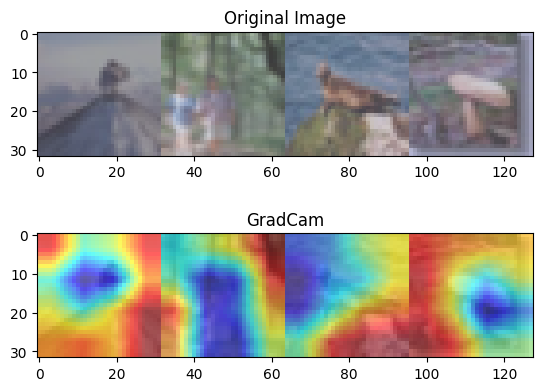

########################################################################################

########################################################################################
Inference of "SE (residuel) + SA"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/SE_SA_1/checkpoint_1.pth
images shape :  torch.Size([4, 3, 32, 32])
input gt labels : 
['mountain', 'forest', 'seal', 'mushroom']
pred labels : 
['lamp', 'spider', 'sunflower', 'streetcar']


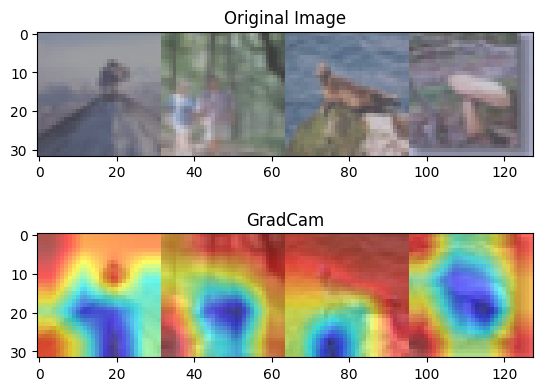

########################################################################################

########################################################################################
Inference of "SE + SA"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/SEC_SA_1/checkpoint_1.pth
images shape :  torch.Size([4, 3, 32, 32])
input gt labels : 
['mountain', 'forest', 'seal', 'mushroom']
pred labels : 
['keyboard', 'leopard', 'sunflower', 'lobster']


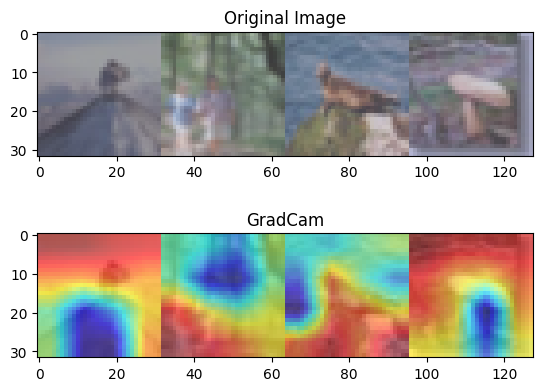

########################################################################################

########################################################################################
Inference of "CBAM"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/CBAM_1/checkpoint_1.pth
images shape :  torch.Size([4, 3, 32, 32])
input gt labels : 
['mountain', 'forest', 'seal', 'mushroom']
pred labels : 
['bridge', 'raccoon', 'rocket', 'couch']


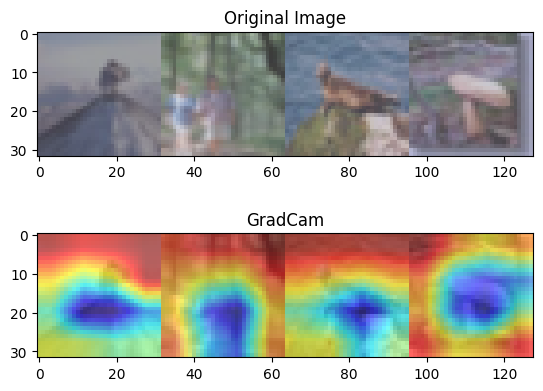

########################################################################################

########################################################################################
Inference of "Our model"
dataset : cifar100
checkpoint : weights/resnet18/cifar100/NEW_1/checkpoint_1.pth
images shape :  torch.Size([4, 3, 32, 32])
input gt labels : 
['mountain', 'forest', 'seal', 'mushroom']
pred labels : 
['couch', 'wolf', 'bottle', 'couch']


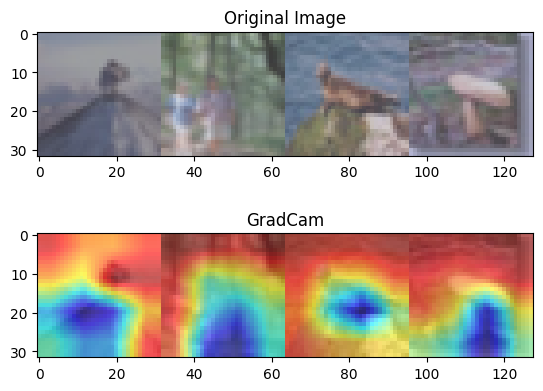

########################################################################################


In [7]:
args = ResNet_agrument()

for bt, bn, bw in zip(resnet_blocks, resnet_names, resnet_checkpoints):
    print()
    print('########################################################################################')
    print('Inference of "%s"' %bn)
    args.block = bt
    args.checkpoint = bw
    resnet_inference(args)
    print('########################################################################################')

# 2 VGG19 Inference

## 2.1 Define functions

In [8]:
def vgg_inference(args):
    #############################################
    # Load dataset
    #############################################
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    if args.dataset == "cifar100":
        num_classes = 100
        classes = class_cifar100
        val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True)
    else:  # default dataset is CIFAR10
        num_classes = 10
        classes = class_cifar10
        val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=args.batch_size, shuffle=False,
            num_workers=args.workers, pin_memory=True)

    print("dataset :", args.dataset)
    print("checkpoint :", args.checkpoint)

    #############################################
    # Load model
    #############################################
    model = vgg.__dict__[args.arch](num_classes, args.block)

    cam_layers = [model.features[52]]

    model.features = torch.nn.DataParallel(model.features)
    if args.cpu:
        model.cpu()
    else:
        model.cuda()
    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    #############################################
    # Evaluate model
    #############################################
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    print("images shape : ", images.shape)
    #img = torchvision.utils.make_grid(images)
    #images = images / 2 + 0.5     # unnormalize
    #npimg = images.numpy()
    #print("npimg shape : ", npimg.shape)
    # torchvision.utils.save_image(images, "gradCAM_seed%d_input.jpg" % seed, nrow=4, normalize=True, range=(-1, 1))
    print("input gt labels : ")
    np_labels = labels.detach().cpu()
    print([classes[int(np_labels[j])] for j in range(args.batch_size)])
    output = model(images)
    maxk = 1
    pred = output.topk(maxk, 1, True, True)
    # print("pred : ", pred)
    print("pred labels : ")
    np_indices = pred.indices.detach().cpu()
    print([classes[int(np_indices[j][0])] for j in range(args.batch_size)])

    #############################################
    # Create CAM
    #############################################
    cam = GradCAM(model=model, target_layers=cam_layers, use_cuda=False if args.cpu else True)
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=False if args.cpu else True)

    grayscale_cams = cam(input_tensor=images)

    original_img = None
    final_cam = None
    for idx, grayscale_cam in enumerate(grayscale_cams):
        tensor_img = images[idx]

        rgb_img = deprocess_image(tensor_img.permute(1, 2, 0).numpy()) / 255.0
        # print(rgb_img)
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        if final_cam is None:
            original_img = rgb_img
            final_cam = cam_image
        else:
            original_img = cv2.hconcat([original_img, rgb_img])
            final_cam = cv2.hconcat([final_cam, cam_image])
    
    fig = plt.figure()
    fig.add_subplot(2, 1, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    
    fig.add_subplot(2, 1, 2)
    plt.imshow(final_cam)
    plt.title("GradCam")
    
    plt.show()

## 2.2 Analysis of inference

In [10]:
args = VGG_agrument()

for bt, bn, bw in zip(vgg_blocks, vgg_names, vgg_checkpoints):
    print()
    print('########################################################################################')
    print('Inference of "%s"' %bn)
    args.block = bt
    args.checkpoint = bw
    vgg_inference(args)
    print('########################################################################################')


########################################################################################
Inference of "VGG19 (base)"


NameError: name 'datasets' is not defined